In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# import dataset
(images, labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(images[...,tf.newaxis]/255, tf.float32),
   tf.cast(labels,tf.int64)))

In [3]:
# custom dense layer
class Dense(tf.keras.layers.Layer):
    def __init__(self,units,activation=None,**kwargs):
        super(Dense,self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
    def build(self,input_shape):
        self.w = self.add_weight(shape=(input_shape[-1],self.units)
                                 ,initializer='random_normal',trainable=True)
        self.b = self.add_weight(shape=(self.units,)
                                ,initializer='random_normal',trainable=True)
        
    def call(self,x):
        return self.activation(tf.matmul(x,self.w)  + self.b)
    

# define model class
class Conv2DModel(tf.keras.Model):
    def __init__(self,units,kernel,strides):
        super(Conv2DModel,self).__init__()
        un1,un2,un3 = units
        ker1,ker2,ker3 = kernel
        str1,str2,str3 = strides
        self.conv1 = tf.keras.layers.Conv2D(un1,ker1,strides=str1,activation='relu',name='conv1')
        self.conv2= tf.keras.layers.Conv2D(un2,ker2,strides=str2,activation='relu',name='conv2')
        self.conv3= tf.keras.layers.Conv2D(un2,ker3,strides=str3,activation='relu',name='conv3')
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense = Dense(un2+un3,activation='relu')
        self.outputs = Dense(10,activation='softmax')
        
    def call(self,inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense(x)
        
        return self.outputs(x)

# initialize the model
model = Conv2DModel([32,64,128],
                  [4,3,3],
                  [1,1,1])

In [4]:
# set loss,metrics and optimizer
loss_fc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,name='train_loss')
optimizer = tf.keras.optimizers.Adam(lr=0.001)
train_loss = tf.keras.metrics.Mean()
val_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_acc')

In [5]:
# training function with autograph 
@tf.function
def train_step(image,targets):
    with tf.GradientTape() as tape:
        pred = model(image)
        losses = loss_fc(targets,pred)
    gradients = tape.gradient(losses,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    train_loss(losses)
    train_accuracy(targets,pred)
    
# validation function with autograph 
@tf.function
def valiation_step(images,targets):
    pred = model(images)
    v_loss = loss_fc(targets,pred)
    val_loss(v_loss)
    val_accuracy(targets,pred)

In [6]:
# train and validation loop
val_acc = []
train_acc = []
v_losses = []
t_losses = []
epochs = 10
batch_size = 64
for epoch in range(epochs):
    for image,labels in dataset.batch(batch_size):
        train_step(image,labels)
        train_acc.append(train_accuracy.result())
        t_losses.append(train_loss.result())
    print('epoch: {}, train_loss {}, train_Accuracy {}'.format(epoch+1,train_loss.result(),train_accuracy.result()))
    for image,labels in dataset.batch(batch_size):
        valiation_step(image,labels)
        val_acc.append(train_accuracy.result())
        v_losses.append(train_loss.result())
    print('epoch: {}, val_loss {}, val_Accuracy {}\n'.format(epoch+1,val_loss.result(),val_accuracy.result()))
    val_loss.reset_states()
    val_accuracy.reset_states()
    train_loss.reset_states()
    train_accuracy.reset_states()

epoch: 1, train_loss 1.5434294939041138, train_Accuracy 0.9182833433151245
epoch: 1, val_loss 1.4916763305664062, val_Accuracy 0.9695666432380676

epoch: 2, train_loss 1.4958425760269165, train_Accuracy 0.965233325958252
epoch: 2, val_loss 1.4884212017059326, val_Accuracy 0.9727166891098022

epoch: 3, train_loss 1.4973558187484741, train_Accuracy 0.9637166857719421
epoch: 3, val_loss 1.4936903715133667, val_Accuracy 0.9674500226974487

epoch: 4, train_loss 1.5008139610290527, train_Accuracy 0.9602500200271606
epoch: 4, val_loss 1.4890512228012085, val_Accuracy 0.972100019454956

epoch: 5, train_loss 1.4874321222305298, train_Accuracy 0.973716676235199
epoch: 5, val_loss 1.4860495328903198, val_Accuracy 0.9750833511352539

epoch: 6, train_loss 1.4947361946105957, train_Accuracy 0.9663666486740112
epoch: 6, val_loss 1.5051151514053345, val_Accuracy 0.9559000134468079

epoch: 7, train_loss 1.501978874206543, train_Accuracy 0.9590833187103271
epoch: 7, val_loss 1.5036184787750244, val_Accu

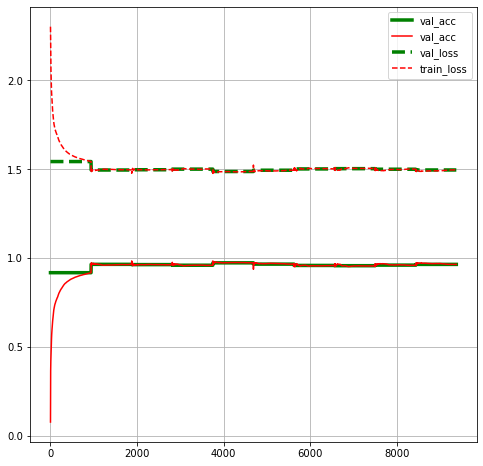

In [13]:
plt.figure(figsize=(8,8))
ax = plt.subplot()
plt.plot(range(len(val_acc)),val_acc,'g-',label='val_acc',linewidth=3.5)
plt.plot(range(len(train_acc)),train_acc,'r-',label='val_acc')
plt.plot(range(len(v_losses)),v_losses,'g--',label='val_loss',linewidth=3.5)
plt.plot(range(len(t_losses)),t_losses,'r--',label='train_loss')
plt.legend()
plt.grid()
plt.show()